<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/ImbalancedLearnPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 不均衡データからモデル作成する際に役立つimbalanced-learnの練習

### 動機
Kaggleでクレジットカードの不正利用を検出するコンペに参加している。  
クレジットカード決済データセットの場合、負例99% 正例1%など非常に偏りのあるデータになる。
クレジットカードに限らず、異常を検知するような課題の場合、このような不均衡なデータセットが多くを占める。
このようなデータセットの取り扱い方を、実装レベルで学んでいなかったので、
これを機に学ぶこととする。  
ちなみにインバランスはアンバランスの名詞らしいけど、現地の人も気にしてないらしいから
覚えなくていい。



[公式](https://imbalanced-learn.org/en/stable/install.html)

### 前提条件
The imbalanced-learn package requires the following dependencies:

numpy (>=1.11)  
scipy (>=0.17)  
scikit-learn (>=0.21)  
keras 2 (optional)  
tensorflow (optional)  

In [0]:
import numpy as np
import scipy as sp
import sklearn as sl

In [0]:
print('numpy=',np.__version__,'scipy=',sp.__version__,'sklearn=',sl.__version__)

numpy= 1.16.4 scipy= 1.3.0 sklearn= 0.21.3


前提条件問題なし

### インストール

In [0]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.5.0)


### プロット関数

In [0]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

### 0. Original

In [0]:
from sklearn.svm import LinearSVC

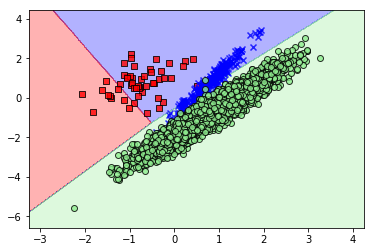

In [0]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
clf = LinearSVC()
linear_svm = clf.fit(X, y)
plot_decision_regions(X, y, clf, resolution=0.02)

### 2.Over-sampling

#### 2.1. A practical guide
[異なるオーバーサンプリングアルゴリズムの比較](https://imbalanced-learn.org/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py)

#### 2.1.1. Naive random over-sampling
少数クラスの新しいサンプルを生成する。
現在利用可能なサンプルを置き換えてランダムにサンプリングすることによって  新しいサンプルを生成する  。  
同じサンプルが複製されるので学習効果は薄いと思われる

[(0, 4674), (1, 4674), (2, 4674)]


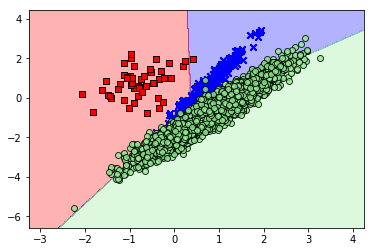

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))
linear_svm = clf.fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

少数クラスの分離が改善されている。  
ただ、他クラスに与える影響もでかい。  
複製されたサンプルは既存のサンプルと同じ位置にプロットされる。  
数字だけでなく文字列を含むデータもサンプリング可能。  
個人的な直感的理解ではマイノリティデータの特徴バイアスを強くするイメージだと考えている。　



#### 2.1.2. From random over-sampling to SMOTE and ADASYN
置換によるランダムサンプリングとは別に、マイノリティクラスをオーバーサンプリングする一般的な2つの方法があります。  
（i）合成マイノリティオーバーサンプリングテクニック（SMOTE）[CBHK2002]  
（ii）適応合成（ADASYN）[HBGL2008]サンプリングメソッド  
これらのアルゴリズムは同じ方法で使用できます。

[(0, 4674), (1, 4674), (2, 4674)]


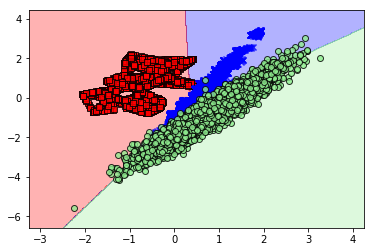

In [0]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items())) 
clf_smote = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_smote, resolution=0.02)

SMOTEはKNNを用いて、二つの少数派クラスの間に引かれた直線状にランダムに点を取るアルゴリズム。  
そのため、少数派クラスの空白地帯が少なくなっている。

[(0, 4673), (1, 4662), (2, 4674)]


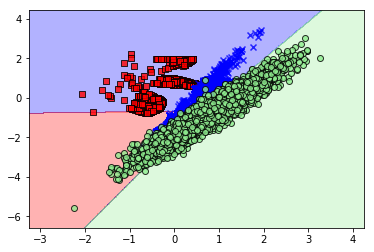

In [0]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_adasyn, resolution=0.02)

ADASYNは間違って分類された元のサンプルの隣にサンプルを生成することに焦点を当てている
以下、論文より抜粋。  
* ADASYNアルゴリズムの重要な考え方は、密度を使用すること
* 少数派と多数派の両方の精度が向上します。クラスを優先して1つのクラスを犠牲にしません  
* ADASYNは複数クラスに一般化可能

確かにプロット図を見るとオリジナルの密度の比率が保たれているように見える。

### 2.1.4. SMOTE variants
SMOTEはインライアーとアウトライアーを接続しますが、ADASYNはアウトライアーのみに焦点を合わせ、どちらの場合も最適でない決定関数につながる可能性があります。  
この点で、SMOTEはサンプルを生成するための3つの追加オプションを提供します。  
これらのメソッドは、最適な決定関数の境界付近のサンプルに焦点を当て、最近傍クラスの反対方向のサンプルを生成します。 これらのバリアントは下図に示されています。

[(0, 4674), (1, 4674), (2, 4674)]


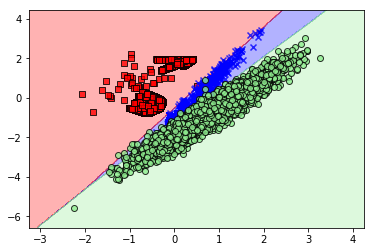

In [0]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf_brdSmote = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_brdSmote, resolution=0.02)

連続的およびカテゴリー的特徴などの混合データ型を処理する場合、提示されたメソッド（クラスRandomOverSamplerを除く）はいずれもカテゴリー的特徴を処理できません。 SMOTENC [CBHK2002]は、カテゴリデータが異なる方法で処理されるSMOTEアルゴリズムの拡張です

In [0]:
# create a synthetic data set with continuous and categorical features
rng = np.random.RandomState(42)
n_samples = 50
X = np.empty((n_samples, 3), dtype=object)
X[:, 0] = rng.choice(['A', 'B', 'C'], size=n_samples).astype(object)
X[:, 1] = rng.randn(n_samples)
X[:, 2] = rng.randint(3, size=n_samples)
y = np.array([0] * 20 + [1] * 30)
print(sorted(Counter(y).items()))

[(0, 20), (1, 30)]


このデータセットでは、最初と最後の機能がカテゴリ機能と見なされます。 これらの機能のインデックスまたはこれらの機能をマークするブールマスクのいずれかを渡すことにより、パラメーターcategorical_featuresを介してこの情報をSMOTENCに提供する必要があります。

In [0]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
print(X_resampled[-5:])

[(0, 30), (1, 30)]
[['A' 0.5246469549655818 2]
 ['B' -0.3657680728116921 2]
 ['A' 0.9344237230779993 2]
 ['B' 0.3710891618824609 2]
 ['B' 0.3327240726719727 2]]


#### 2.2.2。マルチクラス管理
すべてのアルゴリズムは、複数のクラスおよびバイナリクラスの分類で使用できます。 RandomOverSamplerは、サンプル生成中にクラス間情報を必要としません。したがって、各ターゲットクラスは個別にリサンプリングされます。それどころか、ADASYNとSMOTEの両方には、サンプル生成に使用される各サンプルの近傍に関する情報が必要です。各ターゲットクラスを選択し、単一のクラスにグループ化された残りのデータセットに対して必要な統計を計算することにより、1対残りのアプローチを使用しています。

### 3. Under-sampling
[異なるアンダーサンプリングアルゴリズムの比較](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py)　　

#### 3.1. Prototype generation
元のデータセットSが与えられると、プロトタイプ生成アルゴリズムは新しいセットS 'を生成します。  
Prototype generationは、対象クラスのサンプル数を減らしますが、残りのサンプルは元のセットから生成され、選択されません。  
Random under samplingでは有益なデータを削除してしまう可能性があります。一方で、クラスターベースの手法なら各クラスdistinctなデータ群となるため、一部の有益なデータのみを消す事はありません。

[(0, 64), (1, 262), (2, 4674)]


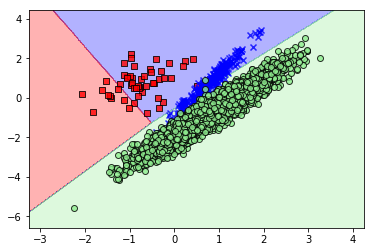

In [0]:
from collections import Counter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                               n_redundant=0, n_repeated=0, n_classes=3,
                               n_clusters_per_class=1,
                               weights=[0.01, 0.05, 0.94],
                               class_sep=0.8, random_state=0)
print(sorted(Counter(y).items()))
clf = LinearSVC().fit(X, y)
plot_decision_regions(X, y, clf, resolution=0.02)

[(0, 64), (1, 64), (2, 64)]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


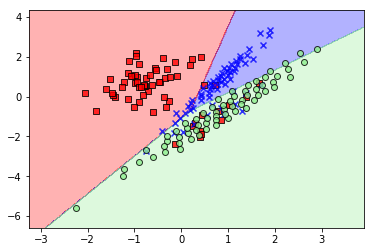

In [0]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

ClusterCentroidsは、サンプル数を減らしてデータクラスターを表す効率的な方法を提供します。この方法では、データをクラスターにグループ化する必要があることに注意してください。さらに、重心の数は、アンダーサンプリングされたクラスターが元のクラスターを代表するように設定する必要があります。

#### 3.2. Prototype selection
Prototype generationアルゴリズムとは対照的に、Prototype selectionアルゴリズムは元のセットからサンプルを選択します。  
さらに、これらのアルゴリズムは、（i）制御されたアンダーサンプリング手法と（ii）クリーニングアンダーサンプリング手法の2つのグループに分けることができます。メソッドの最初のグループは、S 'のサンプル数がユーザーによって指定されるアンダーサンプリング戦略を可能にします。対照的に、アンダーサンプリングテクニックのクリーニングでは、この仕様は許可されず、フィーチャスペースのクリーニングを目的としています。

#### 3.2.1. Controlled under-sampling techniques
RandomUnderSamplerは、対象クラスのデータのサブセットをランダムに選択することにより、データのバランスをとる高速で簡単な方法です。

[(0, 64), (1, 64), (2, 64)]


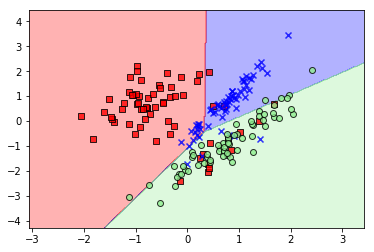

In [0]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

RandomUnderSamplerでは、replacementをTrueに設定することにより、データをブートストラップできます。複数のクラスでのリサンプリングは、各ターゲットクラスを個別に考慮することにより実行されます。

(192, 2)
(181, 2)


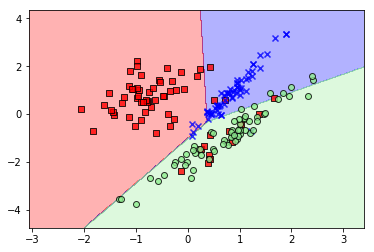

In [0]:
import numpy as np
print(np.vstack([tuple(row) for row in X_resampled]).shape)
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(np.vstack(np.unique([tuple(row) for row in X_resampled], axis=0)).shape)
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

さらに、RandomUnderSamplerを使用すると、異種データをサンプリングできます（たとえば、いくつかの文字列を含む）。

In [0]:
X_hetero = np.array([['xxx', 1, 1.0], ['yyy', 2, 2.0], ['zzz', 3, 3.0]],dtype=np.object)
y_hetero = np.array([0, 0, 1])
X_resampled, y_resampled = rus.fit_resample(X_hetero, y_hetero)
print(X_resampled)
print(y_resampled)

[['xxx' 1 1.0]
 ['zzz' 3 3.0]]
[0 1]



NearMissは、いくつかのヒューリスティックルールを追加してサンプルを選択します[MZ2003]。 NearMissは、パラメーターバージョンで選択できる3種類のヒューリスティックを実装しています。

Minority classのサンプルのうち近くにあるkサンプルからの平均距離が小さいMajority classのサンプルを残します。  

NearMissのヒューリスティックルールは最近傍アルゴリズムに基づいています。したがって、パラメーターn_neighborsおよびn_neighbors_ver3は、scikit-learnのKNeighborsMixinから派生した分類子を受け入れます。前者のパラメーターは、近隣までの平均距離を計算するために使用され、後者は、対象のサンプルの事前選択に使用されます。

特定のクラスをアンダーサンプリングする場合、NearMiss-1はノイズの存在によって変更される可能性があります。通常の場合、境界の隣のサンプルが選択されます。  
NearMiss-2は、最も近いサンプルではなく、最も遠いサンプルに焦点を合わせているため、この効果はありません。ノイズの存在は、主に周辺外れ値の存在下でサンプリングを変更することも想像できます。   
NearMiss-3はおそらく、最初のステップでサンプルを選択するため、ノイズの影響を受けにくいバージョンです。

[(0, 64), (1, 64), (2, 64)]


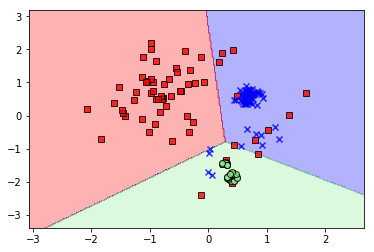

In [0]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_resampled_nm1, y_resampled = nm1.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm1, y_resampled)
plot_decision_regions(X_resampled_nm1, y_resampled, clf, resolution=0.02)

[(0, 64), (1, 64), (2, 64)]


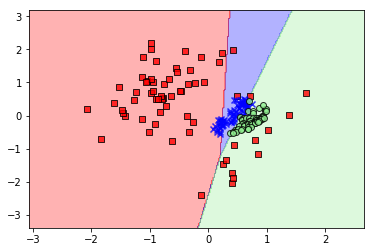

In [0]:
nm2 = NearMiss(version=2)
X_resampled_nm2, y_resampled = nm2.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm2, y_resampled)
plot_decision_regions(X_resampled_nm2, y_resampled, clf, resolution=0.02)

/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:192: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'
/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:192: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


[(0, 64), (1, 44), (2, 56)]


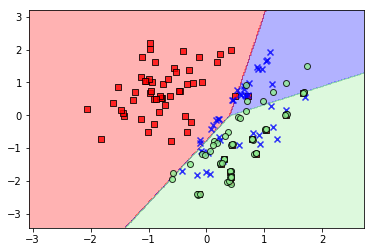

In [0]:
nm3 = NearMiss(version=3)
X_resampled_nm3, y_resampled = nm3.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm3, y_resampled)
plot_decision_regions(X_resampled_nm3, y_resampled, clf, resolution=0.02)

### 3.2.2. Cleaning under-sampling 
アンダーサンプリング手法をクリーニングする場合、各クラスに含めるサンプルの数を指定することはできません。  
実際、各アルゴリズムは、データセットを消去するヒューリスティックを実装しています。

#### 3.2.2.1. Tomek’s links
TomekLinksは、いわゆるTomekのリンクを検出します。
2つのサンプルが互いに最も近い場合、Tomekのリンクが存在します。

#### 3.2.2.2. Edited data set using nearest neighbours

EditedNearestNeighboursは、最近傍アルゴリズムを適用し、近傍と「十分に」一致しないサンプルを削除して、データセットを「編集」します[W1972]。  
アンダーサンプリングされるクラスの各サンプルについて、最近傍が計算され、選択基準が満たされない場合、サンプルは削除されます。現在、2つの選択基準が利用可能です。（i）多数（すなわち、kind_sel = 'mode'）または（ii）すべて（すなわち、kind_sel = 'all'）最も近い隣人は、検査されるサンプルと同じクラスに属している必要があります。

[(0, 64), (1, 213), (2, 4568)]


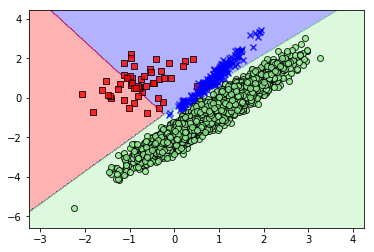

In [0]:
sorted(Counter(y).items())
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

パラメーターn_neighborsを使用すると、scikit-learnのKNeighborsMixinからサブクラス化された分類器を使用して、最近傍を見つけ、特定のサンプルを保持するかどうかを決定できます。

RepeatedEditedNearestNeighboursは、アルゴリズムを複数回繰り返すことでEditedNearestNeighboursを拡張します[T1976]。通常、アルゴリズムを繰り返すと、より多くのデータが削除されます。

[(0, 64), (1, 208), (2, 4551)]


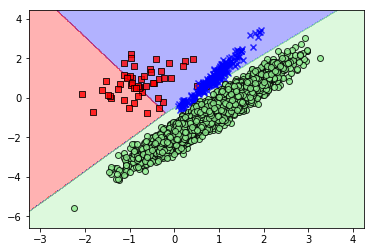

In [0]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours()
X_resampled, y_resampled = renn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

AllKNNは、以前のRepeatedEditedNearestNeighboursとは異なります。内部の最近傍アルゴリズムの近傍の数が各反復で増加するためです[T1976]

[(0, 64), (1, 220), (2, 4601)]


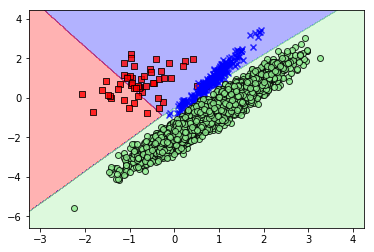

In [0]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
X_resampled, y_resampled = allknn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

#### 3.2.2.3. Condensed nearest neighbors and derived algorithms


CondensedNearestNeighbourは、1つの最近傍ルールを使用して、サンプルを削除するかどうかを繰り返し決定します[H1968]。

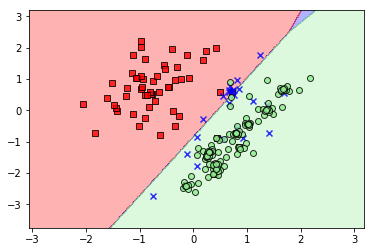

In [0]:
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(random_state=0)
X_resampled, y_resampled = cnn.fit_resample(X, y)
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

CondensedNearestNeighbourはノイズの影響を受けやすく、ノイズの多いサンプルが追加されます。

それどころか、OneSidedSelectionはTomekLinksを使用してノイズの多いサンプルを削除します[KM1997]。

[(0, 64), (1, 174), (2, 4404)]


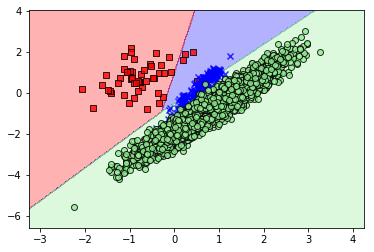

In [0]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

実装では、パラメータn_seeds_Sを設定することにより、元々セットCに入れるシードの数を設定します。

NeighbourhoodCleaningRuleは、データを圧縮するよりもデータをクリーニングすることに焦点を合わせます[J2001]。したがって、EditedNearestNeighboursと3つの最近傍分類子の出力の間で拒否されるサンプルの和集合を使用します。クラスは次のように使用できます。

[(0, 64), (1, 234), (2, 4666)]


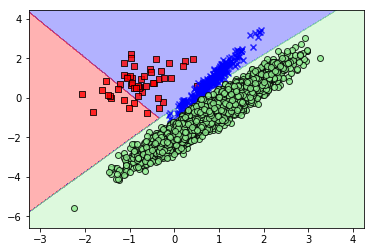

In [0]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

#### 3.2.2.4. Instance hardness threshold
InstanceHardnessThresholdは、分類子がデータでトレーニングされ、確率の低いサンプルが削除される特定のアルゴリズムです[SMMG2014]。クラスは次のように使用できます。

[(0, 64), (1, 64), (2, 64)]


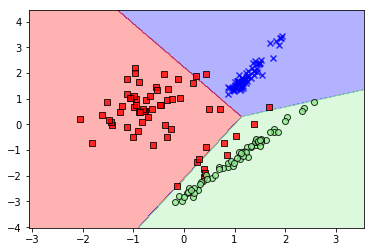

In [0]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=0,
                                estimator=LogisticRegression(
                                    solver='lbfgs', multi_class='auto'))
X_resampled, y_resampled = iht.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

このクラスには2つの重要なパラメーターがあります。推定器は、メソッドpredict_probaを持つscikit-learn分類子を受け入れます。分類器のトレーニングは交差検定を使用して実行され、パラメーターcvは使用するフォールドの数を設定できます。

### 4. Combination of over- and under-sampling

以前にSMOTEを提示し、この方法が周辺の外れ値とインライアーの間の新しいポイントを補間することでノイズの多いサンプルを生成できることを示しました。この問題は、オーバーサンプリングに起因するスペースをクリーニングすることで解決できます。

これに関して、Tomekのリンクと編集された最近傍は、SMOTEオーバーサンプリングを適用してよりクリーンなスペースを取得した後にパイプラインに追加された2つのクリーニング方法です。オーバーサンプリング法とアンダーサンプリング法を組み合わせるための2つの既製のクラス不均衡学習実装は、（i）SMOTETomek [BPM2004]および（ii）SMOTEENN [BBM2003]です。

これらの2つのクラスは、以前のサンプラーと同じパラメーターを持つ他のサンプラーのように使用できます。

[(0, 64), (1, 262), (2, 4674)]
[(0, 4060), (1, 4381), (2, 3502)]


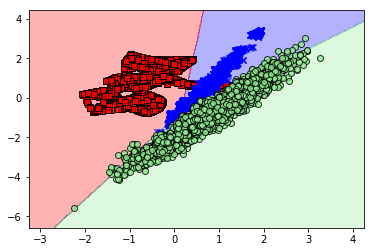

In [0]:
from collections import Counter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
print(sorted(Counter(y).items()))

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

[(0, 4499), (1, 4566), (2, 4413)]


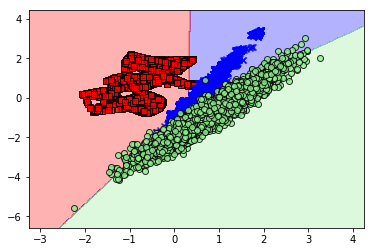

In [0]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

## 5. Ensemble of samplers
### 5.1. Classifier including inner balancing samplers
#### 5.1.1. Bagging classifier
アンサンブル分類器では、バギングメソッドは、ランダムに選択されたさまざまなデータのサブセットにいくつかの推定器を構築します。 scikit-learnでは、この分類子の名前はBaggingClassifierです。ただし、この分類子では、データの各サブセットのバランスを取ることはできません。したがって、不均衡なデータセットでトレーニングする場合、この分類器は多数決クラスを優先します。

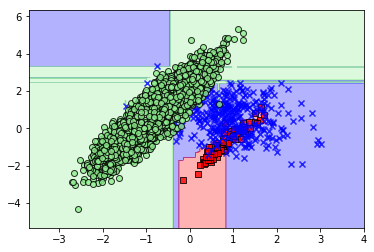

In [0]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=3,
                            n_clusters_per_class=1,
                            weights=[0.01, 0.05, 0.94], class_sep=0.8,
                           random_state=0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0)
bc.fit(X_train, y_train) 
y_pred = bc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)  
plot_decision_regions(X_train, y_train, bc, resolution=0.02)

BalancedBaggingClassifierを使用すると、アンサンブルの各推定器をトレーニングする前に、データの各サブセットをリサンプリングできます。つまり、EasyEnsembleサンプラーの出力と分類子のアンサンブル（つまりBaggingClassifier）を組み合わせます。したがって、BalancedBaggingClassifierはscikit-learn BaggingClassifierと同じパラメーターを取ります。さらに、ランダムアンダーサンプラーの動作を制御するために、sampling_strategyとreplacementの2つの追加パラメーターがあります。

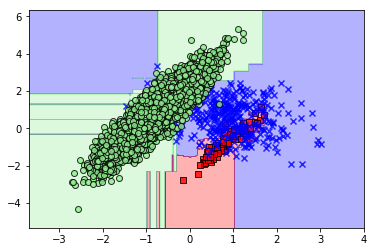

In [0]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, y_train) 
y_pred = bbc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)
plot_decision_regions(X_train, y_train, bbc, resolution=0.02)

#### 5.1.2. Forest of randomized trees
BalancedRandomForestClassifierは、フォレストの各ツリーにバランスの取れたブートストラップサンプル[1CLB2004]を提供する別のアンサンブルメソッドです。このクラスは、sklearn.ensemble.RandomForestClassifierのすべての機能と、特にfeature_importances_属性を提供します。

0.8082309973203445

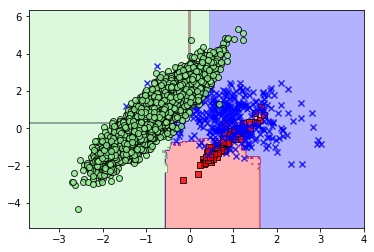

In [0]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train) 
y_pred = brf.predict(X_test) 
plot_decision_regions(X_train, y_train, brf, resolution=0.02)
brf.feature_importances_ 
balanced_accuracy_score(y_test, y_pred) 

#### 5.1.3. Boosting
ブースティングを利用するいくつかの方法が設計されています。

RUSBoostClassifierは、ブースティング反復を実行する前にデータセットをランダムにアンダーサンプリングします

0.6612481897705266

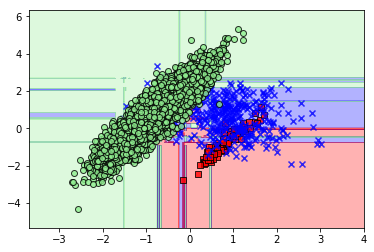

In [0]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(X_train, y_train)  
y_pred = rusboost.predict(X_test)
plot_decision_regions(X_train, y_train, rusboost, resolution=0.02)
balanced_accuracy_score(y_test, y_pred)

バギング分類器の学習者としてAdaBoostを使用する特定のメソッドは、EasyEnsembleと呼ばれます。 EasyEnsembleClassifierを使用すると、バランスの取れたブートストラップサンプルでトレーニングされたAdaBoost学習者をバッグに入れることができます[LWZ2009]。 BalancedBaggingClassifier APIと同様に、次のようにアンサンブルを構築できます。

0.6248477859302602

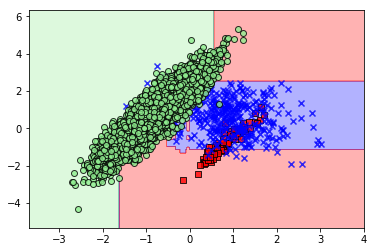

In [0]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=0)
eec.fit(X_train, y_train) 
y_pred = eec.predict(X_test)
plot_decision_regions(X_train, y_train, eec, resolution=0.02)
balanced_accuracy_score(y_test, y_pred) 

## 6. Miscellaneous samplers
### 6.1. Custom samplers
完全にカスタマイズされたサンプラーであるFunctionSamplerが不均衡学習で利用できるため、単一の関数を定義することで独自のサンプラーのプロトタイプをすばやく作成できます。追加のパラメーターは、辞書を受け入れる属性kw_argsを使用して追加できます。次の例は、配列Xおよびyの最初の10個の要素を保持する方法を示しています。

In [0]:
import numpy as np
from imblearn import FunctionSampler
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
def func(X, y):
  return X[:10], y[:10]
sampler = FunctionSampler(func=func)
X_res, y_res = sampler.fit_resample(X, y)
print(np.all(X_res == X[:10]))
print(np.all(y_res == y[:10]))


True
True


このようなサンプラーを使用して、imblearn.pipeline.Pipeline内で簡単に使用できる外れ値棄却推定量を実装する方法を説明します：外れ値棄却推定量を実装するためのカスタマイズされたサンプラー

### 6.2. Custom generators
不均衡学習は、バランスの取れたミニバッチを生成するTensorFlowおよびKerasの特定のジェネレーターを提供します。

#### 6.2.1. TensorFlow generator

imblearn.tensorflow.balanced_batch_generatorにより、インデックスを返す不均衡学習サンプラーを使用して、バランスの取れたミニバッチを生成できます。

In [0]:
X = X.astype(np.float32)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.tensorflow import balanced_batch_generator
training_generator, steps_per_epoch = balanced_batch_generator(
    X, y, sample_weight=None, sampler=RandomUnderSampler(),
    batch_size=10, random_state=42)

generatorおよびsteps_per_epochは、Tensorflowモデルのトレーニング中に使用されます。このジェネレーターの使用方法を説明します。まず、勾配降下によって最適化されるロジスティック回帰モデルを定義できます。

In [0]:
learning_rate, epochs = 0.01, 10
input_size, output_size = X.shape[1], 3
import tensorflow as tf
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == y_true)
# input and output
data = tf.placeholder("float32", shape=[None, input_size])
targets = tf.placeholder("int32", shape=[None])
# build the model and weights
W = init_weights([input_size, output_size])
b = init_weights([output_size])
out_act = tf.nn.sigmoid(tf.matmul(data, W) + b)
# build the loss, predict, and train operator
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=out_act, labels=targets)
loss = tf.reduce_sum(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)
predict = tf.nn.softmax(out_act)
# Initialization of all variables in the graph
init = tf.global_variables_initializer()

初期化されると、バランスの取れたデータのミニバッチを反復処理し、以前に定義された損失を最小化することにより、モデルがトレーニングされます。

### 6.2.2. Keras generator

Kerasは、fit_generatorメソッドを呼び出してモデルをトレーニングすることにより、モデルを定義およびトレーニングできる高レベルのAPIを提供します。説明のために、ロジスティック回帰モデルを定義します。

In [0]:
import keras
y = keras.utils.to_categorical(y, 3)
model = keras.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                             activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])


imblearn.keras.balanced_batch_generatorは、生成されるミニバッチの関連数でバランスの取れたミニバッチジェネレーターを作成します。

In [0]:
from imblearn.keras import balanced_batch_generator
training_generator, steps_per_epoch = balanced_batch_generator(
    X, y, sampler=RandomUnderSampler(), batch_size=10, random_state=42)

次に、ジェネレーターとステップを渡してfit_generatorを呼び出すことができます。

In [0]:
callback_history = model.fit_generator(generator=training_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=10, verbose=0)
print(np.mean(callback_history.history['loss']))

1.3284076910752516



2番目の可能性は、imblearn.keras.BalancedBatchGeneratorを使用することです。このクラスのインスタンスのみがfit_generatorに渡されます。

In [0]:
from imblearn.keras import BalancedBatchGenerator
training_generator = BalancedBatchGenerator(
    X, y, sampler=RandomUnderSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                       epochs=10, verbose=0)
print(np.mean(callback_history.history['loss']))

0.8695757464358682


## 7. Metrics
現在、scikit-learnは、不均衡なデータセットを処理するためのメトリックとしてsklearn.metrics.balanced_accuracy_score（0.20）のみを提供しています。モジュールimblearn.metricsは、文献で分類子の品質を評価するために使用される他のいくつかのメトリックを提供します。

### 7.1. Sensitivity and specificity metrics
感度と特異度は、医療画像でよく知られている指標です。感度（真の陽性率または想起とも呼ばれる）は、明確に分類された陽性サンプルの割合であり、特異性（真の陰性率とも呼ばれます）は、明確に分類された陰性サンプルの割合です。したがって、アプリケーションの分野に応じて、感度/特異性または精度/リコールのメトリックのペアが使用されます。

現在、scikit-learnに実装されているのは精度とリコールメトリックのみです。 sensitive_specificity_support、sensitivity_score、specificity_scoreは、これらのメトリックを使用する可能性を追加します。

### 7.2. Additional metrics specific to imbalanced datasets
geometric_mean_scoreは、クラスごとの感度の積のルートです。この方法は、これらの精度のバランスを保ちながら、各クラスの精度を最大化しようとします。

make_index_balanced_accuracyは任意のメトリックをラップし、パラメーターalphaを使用して特定のクラスにより重要度を与えることができます。

## 8. Dataset loading utilities
imblearn.datasetsパッケージは、sklearn.datasetsパッケージを補完しています。このパッケージは、（i）体系的なベンチマークを実行するための不均衡なデータセットのセットと、（ii）元の均衡の取れたデータセットから不均衡なデータセットを作成するためのユーティリティの両方を提供します。

### 8.1. Imbalanced datasets for benchmark

fetch_datasetsにより、不均衡で2値化された27個のデータセットを取得できます。以下のデータセットが利用可能です：

|  ID	| Name	| Repository & Target	| Ratio	| #S	 | #F |  
|  ---  |  ---  |  --- |  --- |   --- | --- |
|1|	ecoli	|UCI, target: imU	|8.6:1|	336	|7
2	|optical_digits	|UCI, target: 8	|9.1:1	|5,620|	64
3	|satimage	|UCI, target: 4	|9.3:1	|6,435	|36
4	|pen_digits	|UCI, target: 5	|9.4:1	|10,992	|16
5	|abalone	|UCI, target: 7	|9.7:1	|4,177	|10
6	|sick_euthyroid	|UCI, target: sick euthyroid	|9.8:1	|3,163	|42
7	|spectrometer	|UCI, target: >=44	|11:1	|531	|93
8	|car_eval_34	|UCI, target: good, v good	|12:1	|1,728	|21
9	|isolet	|UCI, target: A, B	|12:1	|7,797	|617
10	|us_crime	|UCI, target: >0.65|	12:1	|1,994	|100
11	|yeast_ml8	|LIBSVM, target: 8|	13:1	|2,417	|103
12	|scene	|LIBSVM, target: >one label	|13:1	|2,407	|294
13	|libras_move	|UCI, target: 1	|14:1	|360	|90
14	|thyroid_sick	|UCI, target: sick|	15:1	|3,772	|52
15|	coil_2000	|KDD, CoIL, target: minority	|16:1	|9,822	|85
16|	arrhythmia	|UCI, target: 06	|17:1	|452	|278
17|	solar_flare_m0	|UCI, target: M->0	|19:1	|1,389	|32
18|	oil	|UCI, target: minority	|22:1	|937	|49
19|	car_eval_4	|UCI, target: vgood	|26:1	|1,728	|21
20|	wine_quality	|UCI, wine, target: <=4	|26:1|	4,898	|11
21|	letter_img	|UCI, target: Z	|26:1	|20,000	|16
22|	yeast_me2	|UCI, target: ME2	|28:1	|1,484|8
23|	webpage	|LIBSVM, w7a, target: minority	|33:1|	34,780	|300
24|	ozone_level	|UCI, ozone, data	|34:1	|2,536	|72
25|	mammography	|UCI, target: minority	|42:1	|11,183	|6
26|	protein_homo	|KDD CUP 2004, minority	|11:1|	145,751	|74
27|	abalone_19	|UCI, target: 19	|130:1	|4,177	|10

特定のデータセットは次のように選択できます。

In [0]:
from collections import Counter
from imblearn.datasets import fetch_datasets
ecoli = fetch_datasets()['ecoli']
ecoli.data.shape
print(sorted(Counter(ecoli.target).items()))

[(-1, 301), (1, 35)]


### 8.2. Imbalanced generator

make_imbalanceは、元のデータセットを不均衡なデータセットに変換します。この動作は、他のリサンプリングアルゴリズムと同様に動作するパラメータのsampling_strategyによって駆動されます。 samples_strategyは、キーがクラスに対応し、値がクラス内のサンプル数である辞書として指定できます。

In [0]:
from sklearn.datasets import load_iris
from imblearn.datasets import make_imbalance
iris = load_iris()
sampling_strategy = {0: 20, 1: 30, 2: 40}
X_imb, y_imb = make_imbalance(iris.data, iris.target, sampling_strategy=sampling_strategy)
print(sorted(Counter(iris.target).items()))
print(sorted(Counter(y_imb).items()))

[(0, 50), (1, 50), (2, 50)]
[(0, 20), (1, 30), (2, 40)]


クラスが辞書に記載されていない場合、クラスのすべてのサンプルがパススルーされることに注意してください。

In [0]:
sampling_strategy = {0: 10}
X_imb, y_imb = make_imbalance(iris.data, iris.target,sampling_strategy=sampling_strategy)
sorted(Counter(y_imb).items())

[(0, 10), (1, 50), (2, 50)]

辞書の代わりに、関数を定義して、sampling_strategyに直接渡すことができます。

In [0]:
def ratio_multiplier(y):
    multiplier = {0: 0.5, 1: 0.7, 2: 0.95}
    target_stats = Counter(y)
    for key, value in target_stats.items():
        target_stats[key] = int(value * multiplier[key])
    return target_stats
X_imb, y_imb = make_imbalance(iris.data, iris.target,
                              sampling_strategy=ratio_multiplier)
sorted(Counter(y_imb).items())

[(0, 25), (1, 35), (2, 47)]

さまざまなアルゴリズムについては、make_imbalance関数と、sampling_strategyパラメーターの使用法を参照してください。

## 9. Utilities for Developers

Imbalanced-learnには、開発に役立つ多くのユーティリティが含まれています。これらはimblearn.utilsにあり、さまざまなカテゴリのツールが含まれています。以下のすべての関数とクラスは、imblearn.utilsモジュールにあります。  
これらのユーティリティは、imbalanced-learnパッケージ内で内部的に使用されることを意図しています。それらは、imbalanced-learnのバージョン間で安定することは保証されていません。特に、バックポートは、不均衡な学習依存関係が進化するにつれて削除されます。

### 9.1. Validation Tools
これらは、入力をチェックおよび検証するために使用されるツールです。配列、行列、またはスパース行列を引数として受け入れる関数を作成する場合、該当する場合は以下を使用する必要があります。

* check_neighbors_object：オブジェクトがNNであることを確認します。
* check_target_type：現在のサンプルに準拠するようにターゲットタイプを確認します。
* check_sampling_strategy：サンプリングターゲットが型に一貫性があることを確認し、対応するピクセル数を持つ各ターゲットクラスを含む辞書を返します。

### 9.2. Deprecation
パブリックにアクセス可能なメソッド、関数、属性、またはパラメーターの名前が変更された場合、2つのリリースで古いものを引き続きサポートし、呼び出された/渡された/アクセスされたときに非推奨警告を発行します。たとえば、関数zero_oneの名前がzero_one_lossに変更された場合、非推奨のデコレーター（sklearn.utilsから）をzero_oneに追加し、その関数からzero_one_lossを呼び出します。

In [0]:
from sklearn.utils import deprecated

def zero_one_loss(y_true, y_pred, normalize=True):
    # actual implementation
    pass

@deprecated("Function 'zero_one' was renamed to 'zero_one_loss' "
            "in version 0.13 and will be removed in release 0.15. "
            "Default behavior is changed from 'normalize=False' to "
            "'normalize=True'")
def zero_one(y_true, y_pred, normalize=False):
    return zero_one_loss(y_true, y_pred, normalize)

パブリックにアクセス可能なメソッド、関数、属性、またはパラメーターの名前が変更された場合、2つのリリースで古いものを引き続きサポートし、呼び出された/渡された/アクセスされたときに非推奨警告を発行します。たとえば、関数zero_oneの名前がzero_one_lossに変更された場合、非推奨のデコレーター（sklearn.utilsから）をzero_oneに追加し、その関数からzero_one_lossを呼び出します。

In [0]:
@property
@deprecated("Attribute labels_ was deprecated in version 0.13 and "
            "will be removed in 0.15. Use 'classes_' instead")
def labels_(self):
    return self.classes_


パラメータを廃止する必要がある場合は、DeprecationWarningを適切に使用してください。次の例では、kは廃止され、n_clustersに名前が変更されます。

In [0]:
import warnings

def example_function(n_clusters=8, k=None):
    if k is not None:
        warnings.warn("'k' was renamed to n_clusters in version 0.13 and "
                      "will be removed in 0.15.", DeprecationWarning)
        n_clusters = k

これらの例のように、警告メッセージには、廃止予定が発生したバージョンと古い動作が削除されるバージョンの両方が常に表示されます。バージョン0.x-devで廃止が発生した場合、メッセージはバージョン0.xで廃止が発生したことを示し、削除は0.（x + 2）になります。たとえば、非推奨がバージョン0.18-devで発生した場合、メッセージはバージョン0.18で発生したことを伝え、古い動作はバージョン0.20で削除されます。

さらに、上記の非推奨警告と同じ情報を思い出して、非推奨ノートをdocstringに追加する必要があります。 .. deprecated ::ディレクティブを使用します：


scikit-learnが提供するすべての機能の上に。 imbalanced-learnはdeprecate_parameter：を提供します。これは、サンプラーのパラメーター（属性）を別のパラメーターで非推奨にするために使用されます。

### 9.3. Testing utilities
現在、imbalanced-learnは警告管理ユーティリティを提供します。この機能はpytestでマージされ、pytestリリースに含まれるときに削除されます。

Python 2.7以降を使用している場合、この関数をコンテキストマネージャーとして使用できます。

In [0]:
import warnings
from imblearn.utils.testing import warns
with warns(RuntimeWarning):
   warnings.warn("my runtime warning", RuntimeWarning)

with warns(RuntimeWarning):
   pass

Failed: ignored

In [0]:
with warns(RuntimeWarning):
   warnings.warn(UserWarning)

Failed: ignored

コンテキストマネージャーフォームでは、キーワード引数の一致を使用して、例外がテキストまたは正規表現に一致することをアサートできます。

In [0]:
import warnings
from imblearn.utils.testing import warns
with warns(UserWarning, match='must be 0 or None'):
    warnings.warn("value must be 0 or None", UserWarning)

with warns(UserWarning, match=r'must be \d+$'):
    warnings.warn("value must be 42", UserWarning)

with warns(UserWarning, match=r'must be \d+$'):
    warnings.warn("this is not here", UserWarning)

AssertionError: ignored

### 感想
UnderSamplingとOverSamplingの様々な手法を知れた。  
問題は、それぞれのアルゴリズムの使い分けが適切に出来るかどうかだが、  
これは実践を通して感覚を身に着けていくしかないと感じた。